# Portfolio exercises:
### 1. load and inspect the data 
- what are missing/problematic entries?

### 2. data exploration and cleaning 
- remove, fill, change data (if you think this makes sense or is necessary/beneficial)
- inspect two different types of labels (`label` and `infection_type`). How many classes are there and is there any bias? If so, is there anything we have to take care of?


### 3. Prepare data for machine learning: 
- Separate data / labels
- Split into train ~70% / validation ~15% / test ~15%

### 4. Build an image generator pipeline
- Use keras `ImageDataGenerator` to define a `train_generator` and a `validation_generator`.
- Use the generator to recale the pixel values and to reshape the image to the desired format.

### 5. Train your own custom-made CNN (pneumonia yes/no prediction)
- Define a conventional CNN image classifier (convolution-pooling steps, followed by dense layers) to predict if a patient has pneumonia or not.

### 6. Use transfer learning to train a CNN classifier (pneumonia yes/no prediction)
- Pick any suitable CNN you like (e.g. Resnet-50, Densenet, MobileNet...) and create your own image classifier from there.

### 7. Evaluate both models
- Evaluate the models on data other than the training data.
- Plot a ROC curve and compute the area under the curve (AUC). What does this tell you?
- Compare to your custom-made CNN: which one achieves better results (and why)? Which one trains faster (and why)? What would you prefer to use in an actual medical application?

### 8. Train a CNN for a multi-class prediction (bacteria, virus, none)
- Adapt a CNN (e.g. pick one form 5. or 6.) and modify it to predict if a patient has a bacterial or a virus infection, or none of both using the `infection_type` column as label.
- This requires to also adapt the generators.

### 9. Evaluate the multi-class model
- Evaluate the multi-class prediction model, simliar to what you did in (7.). Again also include a ROC curve (now of course for all 3 possible labels).
- Is the performance comparable, better, worse than the pneumonia/no pneumonia case?
- Which label can be predicted with the highest precision?

### 10. Possible improvements
Try two possible strategies to improve the results you got on 8. and 9.
- Data augmentation.
- Model fine tuning. This refers to the training of a large network with lower learning rate, but with more layers of the base model being set to `trainable`.
We haven't done this before, so here some example code of how to "unfreeze" some layers and make them trainable again:
```python
# Now: unfreeze some of the base model layers and do a second pass of training
for layer in model.layers[:100]:
    layer.trainable = False
for layer in model.layers[100:]:
    layer.trainable = True
``` 
You can still use the `Adam` optimizer, but preferably with a much lower learning rate, maybe `1e-5`.
- Do you see any promising effect of one or both of those strategies?


## Final submission:
Please address all the above mentioned points in this notebook (e.g., using text cells where needed for explanations or answers). Obviously, you can use code snippets from notebooks we have already worked on during the live coding sessions.


### Happy hacking!!!

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## The Dataset

Similar to former notebooks where we worked with the [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315), where here have a smaller X-ray dataset containing 5856 images.
Instead of 14 different diseases we will here concentrate on much fewer possible labels so that *hopefully* the number of images is enough to train good deep learning classifiers.

The images are distributed accross two folders (`NORMAL` and `PNEUMONIA`), the related metadata can be found in `x_ray_metadata_portfolio.csv` but actually also is reflected in the image file names.

### Load and inspect the data

## Import metadata

In [129]:
path_data = "ChestXray_pneumonia_prediction/"
filename = "x_ray_metadata_portfolio.csv"
metadata = pd.read_csv(os.path.join(path_data, filename))

In [3]:
metadata.head(20)

,patient_id,label,infection_type,folder,image
0,0001,normal,none,NORMAL,IM-0001-0001.jpeg
1,0003,normal,none,NORMAL,IM-0003-0001.jpeg
2,0005,normal,none,NORMAL,IM-0005-0001.jpeg
3,0006,normal,none,NORMAL,IM-0006-0001.jpeg
4,0007,normal,none,NORMAL,IM-0007-0001.jpeg
5,0009,normal,none,NORMAL,IM-0009-0001.jpeg
6,0010,normal,none,NORMAL,IM-0010-0001.jpeg
7,0011,normal,none,NORMAL,IM-0011-0001-0001.jpeg
8,0011,normal,none,NORMAL,IM-0011-0001-0002.jpeg
9,0011,normal,none,NORMAL,IM-0011-0001.jpeg


In [4]:
metadata.describe()

,patient_id,label,infection_type,folder,image
count,5856,5856,5856,5856,5856
unique,2790,2,3,2,5856
top,person23,pneumonia,bacteria,PNEUMONIA,IM-0001-0001.jpeg
freq,31,4273,2780,4273,1


In [5]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   patient_id      5856 non-null   object
 1   label           5856 non-null   object
 2   infection_type  5856 non-null   object
 3   folder          5856 non-null   object
 4   image           5856 non-null   object
dtypes: object(5)
memory usage: 228.9+ KB


In [6]:
metadata.isnull().sum()

patient_id        0
label             0
infection_type    0
folder            0
image             0
dtype: int64

In [130]:
print(
    f"The total patient ids are {metadata['patient_id'].count()}, \
from those the unique ids are {len(metadata['patient_id'].unique())} "
)

The total patient ids are 5856, from those the unique ids are 2790 


In [8]:
metadata.value_counts("patient_id").head(20)

patient_id
person23      31
person124     20
person441     18
person30      15
person1320    14
person348     13
person326     12
person281     12
person1411    12
person26      12
person266     12
person258     11
person51      11
person1343    11
person445     11
person294     11
person61      11
person325     10
person371     10
person109     10
dtype: int64

In [9]:
mask = metadata.patient_id == "person23"
metadata[mask]

,patient_id,label,infection_type,folder,image
3494,person23,pneumonia,bacteria,PNEUMONIA,person23_bacteria_100.jpeg
3495,person23,pneumonia,bacteria,PNEUMONIA,person23_bacteria_101.jpeg
3496,person23,pneumonia,bacteria,PNEUMONIA,person23_bacteria_102.jpeg
3497,person23,pneumonia,bacteria,PNEUMONIA,person23_bacteria_103.jpeg
3498,person23,pneumonia,bacteria,PNEUMONIA,person23_bacteria_104.jpeg
3499,person23,pneumonia,bacteria,PNEUMONIA,person23_bacteria_105.jpeg
3500,person23,pneumonia,bacteria,PNEUMONIA,person23_bacteria_106.jpeg
3501,person23,pneumonia,bacteria,PNEUMONIA,person23_bacteria_107.jpeg
3502,person23,pneumonia,bacteria,PNEUMONIA,person23_bacteria_78.jpeg
3503,person23,pneumonia,bacteria,PNEUMONIA,person23_bacteria_79.jpeg


In [10]:
# beware of data leakage!

In [11]:
columns = metadata.columns
print(columns.values)

['patient_id' 'label' 'infection_type' 'folder' 'image']


In [12]:
type(metadata)

pandas.core.frame.DataFrame

In [131]:
metadata["folder"].value_counts()

PNEUMONIA    4273
NORMAL       1583
Name: folder, dtype: int64

In [132]:
metadata["label"].value_counts()

pneumonia    4273
normal       1583
Name: label, dtype: int64

In [133]:
metadata["patient_id"].value_counts()

person23      31
person124     20
person441     18
person30      15
person1320    14
              ..
person1580     1
0907           1
person1579     1
person1577     1
0001           1
Name: patient_id, Length: 2790, dtype: int64

In [134]:
metadata["infection_type"].value_counts()

bacteria    2780
none        1583
virus       1493
Name: infection_type, dtype: int64

What are missing/ problematic entries?

There are no NaN entries, so no missing entries.

But there are problems:
- possibility  of data leakage: some patients occur several times in the dataset, from 5856	ID entries, only 2790 are unique. It's important to ensure that all the data/ all the images of one patient are in the same dataset when doing the train/test/val split, otherwise the predictions could turn out to be too optimistic.
- the dataset is unbalanced, only about 27% of the patients in the dataset have the label "NORMAL" (are healthy)
- also when exploring the infection_type, one sees some inbalance, since of all the sick patients 2780 have a bacterial infection and only 1493 have viral infection
- the patient_id looks rather heterogenous, some IDs contain words ("patient23"), some don't ("0001")
- "label" and "folder" seem to have the same content (not necessarily problematic, but remarkable)

In [21]:
# use one hot encoding to transform data?

In [135]:
# define column in metadata with whole image path (for later)

path_images = "ChestXray_pneumonia_prediction/"
metadata['image_path'] = path_images + metadata['folder'] + '/' + metadata['image']

In [136]:
target_patient_id = 'person111'

# only rows concerning the selected patient
target_rows = metadata[metadata['patient_id'] == target_patient_id]
target_rows

,patient_id,label,infection_type,folder,image,image_path
1827,person111,pneumonia,bacteria,PNEUMONIA,person111_bacteria_533.jpeg,ChestXray_pneumonia_prediction/PNEUMONIA/perso...
1828,person111,pneumonia,bacteria,PNEUMONIA,person111_bacteria_534.jpeg,ChestXray_pneumonia_prediction/PNEUMONIA/perso...
1829,person111,pneumonia,bacteria,PNEUMONIA,person111_bacteria_535.jpeg,ChestXray_pneumonia_prediction/PNEUMONIA/perso...
1830,person111,pneumonia,bacteria,PNEUMONIA,person111_bacteria_536.jpeg,ChestXray_pneumonia_prediction/PNEUMONIA/perso...
1831,person111,pneumonia,bacteria,PNEUMONIA,person111_bacteria_537.jpeg,ChestXray_pneumonia_prediction/PNEUMONIA/perso...
1832,person111,pneumonia,virus,PNEUMONIA,person111_virus_209.jpeg,ChestXray_pneumonia_prediction/PNEUMONIA/perso...
1833,person111,pneumonia,virus,PNEUMONIA,person111_virus_210.jpeg,ChestXray_pneumonia_prediction/PNEUMONIA/perso...
1834,person111,pneumonia,virus,PNEUMONIA,person111_virus_212.jpeg,ChestXray_pneumonia_prediction/PNEUMONIA/perso...


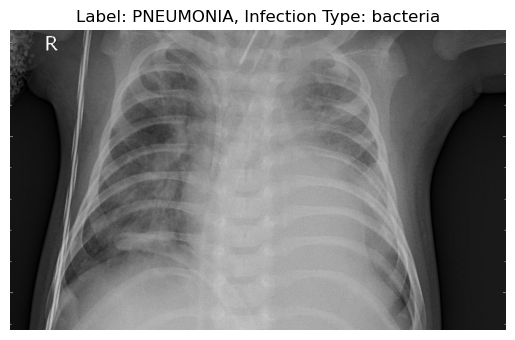

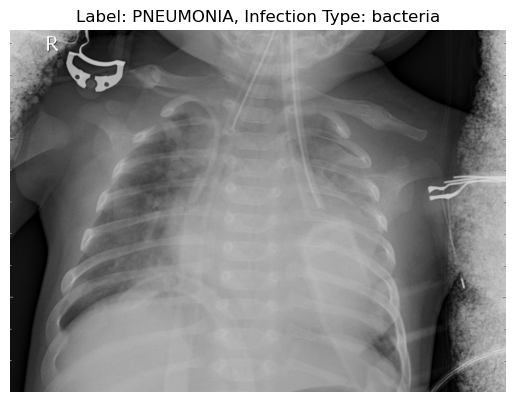

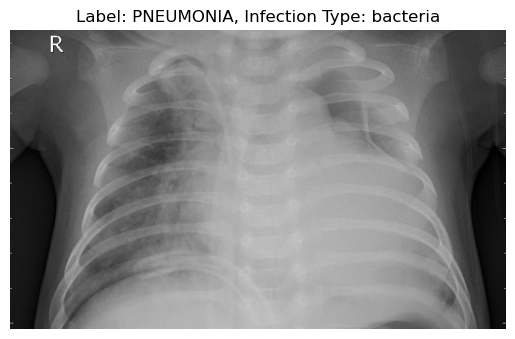

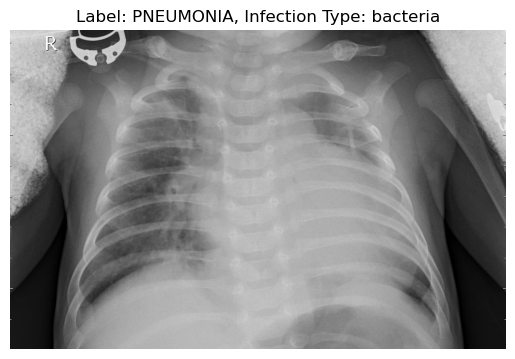

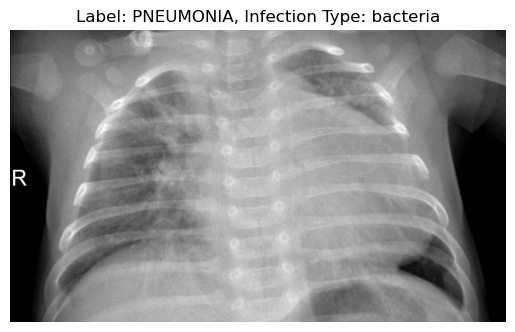

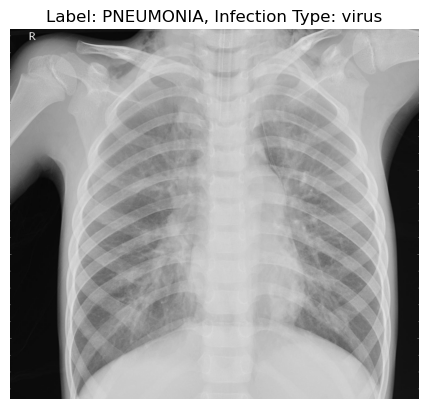

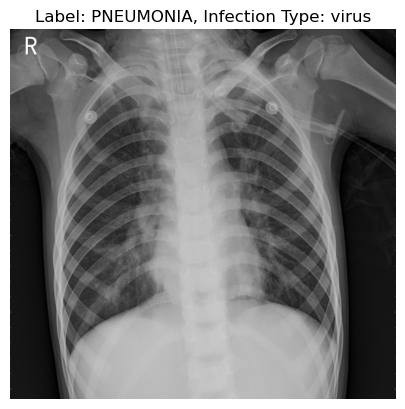

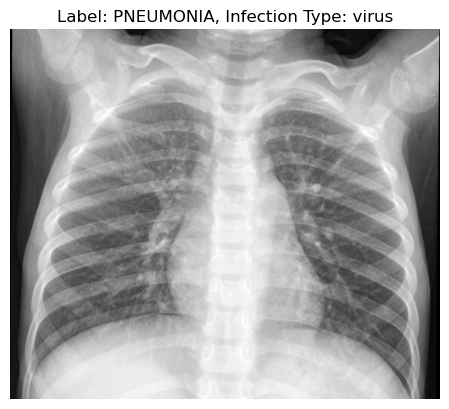

In [24]:
# plot the selected target_patient_id with the label

# Iterate over each row and plot the images with label
for i, row in target_rows.iterrows():
    image_path = row['image_path']
    image = Image.open(image_path)

    # Get the label of the image
    folder_label = row['folder']
    infection_label = row['infection_type']

    # Plot the image with labels
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {folder_label}, Infection Type: {infection_label}")
    plt.axis('off')
    plt.show()

## 2. Data exploration and Cleaning

I will keep all entries, but not all columns. The "folder" column and the "label" column have the same information, so I will drop the "folder" column.
So far, I think it is not necessary to generate unique IDs for each entry, it's fine to just use the patientID. Also the heterogenous way of storing patient IDs shouldn't pose a problem at the moment, as long as we can do the train/test split while avoiding data leakage.

In [25]:
# is the content of "folder" and "label" the same?
metadata['folder'] = metadata['folder'].str.lower()
print(metadata['folder'].equals(metadata['label']))

True


In [26]:
metadata = metadata.drop(columns=['folder'])
metadata

,patient_id,label,infection_type,image,image_path
0,0001,normal,none,IM-0001-0001.jpeg,ChestXray_pneumonia_prediction/NORMAL/IM-0001-...
1,0003,normal,none,IM-0003-0001.jpeg,ChestXray_pneumonia_prediction/NORMAL/IM-0003-...
2,0005,normal,none,IM-0005-0001.jpeg,ChestXray_pneumonia_prediction/NORMAL/IM-0005-...
3,0006,normal,none,IM-0006-0001.jpeg,ChestXray_pneumonia_prediction/NORMAL/IM-0006-...
4,0007,normal,none,IM-0007-0001.jpeg,ChestXray_pneumonia_prediction/NORMAL/IM-0007-...
...,...,...,...,...,...
5851,person99,pneumonia,virus,person99_virus_183.jpeg,ChestXray_pneumonia_prediction/PNEUMONIA/perso...
5852,person9,pneumonia,bacteria,person9_bacteria_38.jpeg,ChestXray_pneumonia_prediction/PNEUMONIA/perso...
5853,person9,pneumonia,bacteria,person9_bacteria_39.jpeg,ChestXray_pneumonia_prediction/PNEUMONIA/perso...
5854,person9,pneumonia,bacteria,person9_bacteria_40.jpeg,ChestXray_pneumonia_prediction/PNEUMONIA/perso...


In [27]:
metadata["infection_type"].value_counts()

bacteria    2780
none        1583
virus       1493
Name: infection_type, dtype: int64

In [28]:
metadata["label"].value_counts()

pneumonia    4273
normal       1583
Name: label, dtype: int64

The label "infection_type" has three classes: bacteria, none and virus

If the patient has no pneumonia, they are classified as none. Otherwise, the infection is either classified as bacterial or viral. There are 3 classes -> multi-class problem

The label "label" has two classes: pneumonia and normal, so either sick with pneumonia or not.
There are 2 classes -> binary class problem

"none" in "infection type" and "normal" in "label" have 1583 entries, since they both mean that a patient has no pneumonia. As I already pointed out in 1), there is bias/the dataset is unbalanced, because there are much more patients with pneumonia than without and also, inside the group of people with pneuomnia, much more people with bacterial infection than viral infection.

Bias/ unbalanced datasets lead to rather bad decisions, since the algorithm learns to rather predict the overrepresented label than the underrepresented one.

There is something we can do -> oversampling, data augmentation

## 3. Prepare data for machine learning

A "normal" train/test/val split is not possible anymore, since one patient can have multiple entries and we need to avoid data leakage. Before doing the split, we need to find all unique patient_ids and do the split based on them.

In [137]:
unique_patient_ids = metadata['patient_id'].unique()

train_ids, test_ids = train_test_split(unique_patient_ids, test_size=0.3, random_state=0)

test_ids, val_ids = train_test_split(test_ids, test_size=0.50, random_state=0)

train_df = metadata[metadata['patient_id'].isin(train_ids)]
val_df = metadata[metadata['patient_id'].isin(val_ids)]
test_df = metadata[metadata['patient_id'].isin(test_ids)]

In [138]:
print(f"Training set size: {train_df.shape}")
print(f"Validation set size: {val_df.shape}")
print(f"Test set size: {test_df.shape}")

Training set size: (4169, 6)
Validation set size: (818, 6)
Test set size: (869, 6)


In [139]:
print(train_df.shape, val_df.shape, test_df.shape)

(4169, 6) (818, 6) (869, 6)


In [140]:
train_df["label"].value_counts()

pneumonia    3074
normal       1095
Name: label, dtype: int64

In [141]:
val_df["label"].value_counts()

pneumonia    569
normal       249
Name: label, dtype: int64

In [142]:
test_df["label"].value_counts()

pneumonia    630
normal       239
Name: label, dtype: int64

In [143]:
# check for data leakage

print('Data leakage =', train_df['patient_id'].isin(val_df['patient_id']).any() or train_df['patient_id'].isin(test_df['patient_id']).any())

Data leakage = False


In [144]:
print('label distribution:')
print('')
print('Train     pneumonia:', train_df['label'].value_counts()[0]/len(train_df))
print('Remaining pneumonia:', val_df['label'].value_counts()[0]/len(val_df))
print('Remaining pneumonia:', test_df['label'].value_counts()[0]/len(test_df))
print()
print('Train     normal:', train_df['label'].value_counts()[1]/len(train_df))
print('Remaining pneumonia:', val_df['label'].value_counts()[1]/len(val_df))
print('Remaining pneumonia:', test_df['label'].value_counts()[1]/len(test_df))

label distribution:

Train     pneumonia: 0.7373470856320461
Remaining pneumonia: 0.69559902200489
Remaining pneumonia: 0.7249712313003452

Train     normal: 0.26265291436795396
Remaining pneumonia: 0.30440097799511
Remaining pneumonia: 0.27502876869965476


The dataset is unbalanced -> Normally I would use oversampling, but I think in the lesson it was said that in this specific dataset, we will get a good ROC Curve even without oversampling, so I will leave it for now :)

## 4. Build an image generator pipeline

In [145]:
# Import data generator from keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [146]:
# Normalize images
image_generator = ImageDataGenerator(
    rescale=1.0/255 # rescale pixel values
)

In [147]:
# tensorflow docu:
# .flow_from_dataframe() takes a dataframe and path to directory -> generates batches
# generated batches contain augmented/normalized data
# class_mode -> mode for yielding targets
# binary: 1D numpy array of binary labels
# categorical: 2D numpy array of one-hot encoded labels, supports multi-label output
# input: images identical to input images
# multi-output: list with the values of the different columns
# raw: numpy array of values in y_col
# sparse: 1D numpy array of int labels
# None: no targets returned

In [148]:
# Define the data generators

# the image generator does a one hot encoding, stores label in binary

train_generator = image_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col="image_path",
        y_col="label",
        target_size=(320,320), # reshape to desired format
        batch_size=32,
        class_mode="binary", # raw for already one hot encoded labels
        color_mode="grayscale")

val_generator = image_generator.flow_from_dataframe(
        dataframe=val_df,
        x_col="image_path",
        y_col="label",
        target_size=(320,320), # reshape to desired format
        batch_size=32,
        class_mode="binary",
        shuffle=False,
        color_mode="grayscale")

test_generator = image_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col="image_path",
        y_col="label",
        target_size=(320,320), # reshape to desired format
        batch_size=32,
        class_mode="binary",
        shuffle=False,
        color_mode="grayscale")


Found 4169 validated image filenames belonging to 2 classes.
Found 818 validated image filenames belonging to 2 classes.
Found 869 validated image filenames belonging to 2 classes.


## Train your own custom-made CNN (pneumonia yes/no prediction)

In [46]:
batch = next(train_generator)

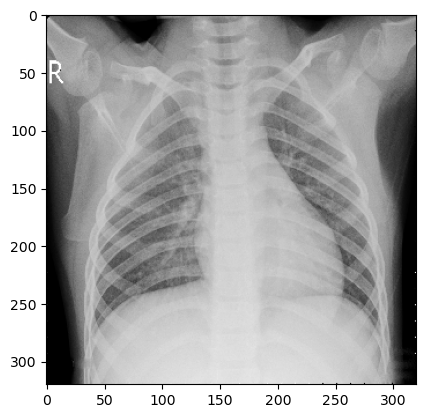

In [47]:
first_image = batch[0][0]
first_image.min(), first_image.max()
plt.imshow(first_image, cmap="gray")

In [48]:
import keras

In [49]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten
from keras.models import Model

In [149]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

inputs = Input(shape=(320, 320, 1))
#Convolution part
x = Conv2D(32, (3,3), activation="relu")(inputs)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation="relu")(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(128, (3,3), activation="relu")(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(128, (3,3), activation="relu")(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(128, (3,3), activation="relu")(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(128, (3,3), activation="relu")(x)
x = MaxPooling2D((2,2))(x)


# Dense (decision) part

x = Flatten()(x)
x = Dense(64, activation="relu")(x)
outputs =  Dense(1, activation="sigmoid")(x) #"linear", "relu", "softmax"(muticlass prediction)

cnn_customized_model = Model(inputs=inputs, outputs=outputs)
cnn_customized_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 320, 320, 1)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 318, 318, 32)      320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 159, 159, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 157, 157, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 78, 78, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 76, 76, 128)       7385

In [150]:
import tensorflow as tf

metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

# Compile the model
cnn_customized_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics="accuracy") #metrics)

In [151]:
from tqdm.keras import TqdmCallback

In [152]:
# save model checkpoints
cnn_customized_path = "portfolio_checkpoints/cnn_customized.ckpt"

# Create a callback that saves the model's weights
save_weights = tf.keras.callbacks.ModelCheckpoint(filepath=cnn_customized_path,
                                                 save_weights_only=True,    # saving only the weights, because we have the architecture of the model
                                                 verbose=1, 
                                                 monitor='val_accuracy',    # we are monitoring the accuracy on the validation set
                                                 mode='max',                # the greatest accuracy on the validation is the best outcome
                                                 save_best_only=True)       # we only want to save the best model. The other chechpoints are not interesting to us

maybe use early stopping?

In [100]:
# Train the model
history = cnn_customized_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=1,
    callbacks=[save_weights],  # Pass callback to training
)

Epoch 1/10
131/131 [==============================] - ETA: 0s - loss: 0.4300 - accuracy: 0.8036
Epoch 1: val_accuracy improved from -inf to 0.89976, saving model to portfolio_checkpoints\cnn_customized.ckpt
131/131 [==============================] - 197s 2s/step - loss: 0.4300 - accuracy: 0.8036 - val_loss: 0.2509 - val_accuracy: 0.8998
Epoch 2/10
131/131 [==============================] - ETA: 0s - loss: 0.2165 - accuracy: 0.9168
Epoch 2: val_accuracy improved from 0.89976 to 0.91932, saving model to portfolio_checkpoints\cnn_customized.ckpt
131/131 [==============================] - 205s 2s/step - loss: 0.2165 - accuracy: 0.9168 - val_loss: 0.2263 - val_accuracy: 0.9193
Epoch 3/10
131/131 [==============================] - ETA: 0s - loss: 0.1700 - accuracy: 0.9393
Epoch 3: val_accuracy improved from 0.91932 to 0.92787, saving model to portfolio_checkpoints\cnn_customized.ckpt
131/131 [==============================] - 218s 2s/step - loss: 0.1700 - accuracy: 0.9393 - val_loss: 0.1917 

In [108]:
# epochs take about 200s
# loss in last epoch: 0.1054
# accuracy in last epoch: 0.9652
# val_loss in last epoch: 0.1751 (went up in the last four epochs)
# val_accuracy: 0.9352 (went down in last three epochs)

cnn_customized_model.load_weights(cnn_customized_path)

I trained without callbacks before and it seems to me that the training takes longer with callbacks. But I read that it shouldn't have an influence on the duration of the training..


## 6. Use transfer learning to train a CNN classifier (pneumonia yes/no prediction)

In [61]:
# Define the data generators
# use rgb as color_mode, since prebuilt architectures only take input with a shape with 3 color channels

densenet_train_generator = image_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col="image_path",
        y_col="label",
        target_size=(320,320), # reshape to desired format
        batch_size=32,
        class_mode="binary",
        color_mode="rgb")

densenet_val_generator = image_generator.flow_from_dataframe(
        dataframe=val_df,
        x_col="image_path",
        y_col="label",
        target_size=(320,320), # reshape to desired format
        batch_size=32,
        class_mode="binary",
        shuffle=False,
        color_mode="rgb")

densenet_test_generator = image_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col="image_path",
        y_col="label",
        target_size=(320,320), # reshape to desired format
        batch_size=32,
        class_mode="binary",
        shuffle=False,
        color_mode="rgb")

Found 4169 validated image filenames belonging to 2 classes.
Found 818 validated image filenames belonging to 2 classes.
Found 869 validated image filenames belonging to 2 classes.


In [62]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the DenseNet121 model but exclude the top layer (classification layer)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(320, 320, 3))

# own top layer for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the actual model
model_densenet = Model(inputs=base_model.input, outputs=predictions)
model_densenet.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 326, 326, 3)  0          ['input_4[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 160, 160, 64  9408        ['zero_padding2d_4[0][0]']       
                                )                                                           

 conv2_block4_0_relu (Activatio  (None, 80, 80, 160)  0          ['conv2_block4_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 80, 80, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 80, 80, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 80, 80, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block2_0_relu (Activatio  (None, 40, 40, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 40, 40, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 40, 40, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 40, 40, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)       

 ization)                                                                                         
                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 40, 40, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 40, 40, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 40, 40, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_blo

 conv3_block10_concat (Concaten  (None, 40, 40, 448)  0          ['conv3_block9_concat[0][0]',    
 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 40, 40, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 40, 40, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 40, 40, 128)  57344       ['conv3_block11_0_relu[0][0]']   
          

                                                                                                  
 conv4_block2_concat (Concatena  (None, 20, 20, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 20, 20, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 20, 20, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block7_0_relu (Activatio  (None, 20, 20, 448)  0          ['conv4_block7_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 20, 20, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 20, 20, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 20, 20, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block11_1_relu (Activati  (None, 20, 20, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 20, 20, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 20, 20, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 20, 20, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)

 ate)                                                             'conv4_block15_2_conv[0][0]']   
                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 20, 20, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 20, 20, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 20, 20, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block20_1_conv (Conv2D)  (None, 20, 20, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 20, 20, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 20, 20, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 20, 20, 32)   36864       ['conv4_block20_1_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 20, 20, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 20, 20, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 20, 20, 1024  4096        ['conv4_block24_concat[0][0]']   
                                )                                                                 
                                                                                                  
 pool4_rel

 ization)                                                                                         
                                                                                                  
 conv5_block4_1_relu (Activatio  (None, 10, 10, 128)  0          ['conv5_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block4_2_conv (Conv2D)   (None, 10, 10, 32)   36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 10, 10, 640)  0          ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_blo

 conv5_block8_concat (Concatena  (None, 10, 10, 768)  0          ['conv5_block7_concat[0][0]',    
 te)                                                              'conv5_block8_2_conv[0][0]']    
                                                                                                  
 conv5_block9_0_bn (BatchNormal  (None, 10, 10, 768)  3072       ['conv5_block8_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 10, 10, 768)  0          ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 10, 10, 128)  98304       ['conv5_block9_0_relu[0][0]']    
          

 on)                                                                                              
                                                                                                  
 conv5_block13_1_conv (Conv2D)  (None, 10, 10, 128)  114688      ['conv5_block13_0_relu[0][0]']   
                                                                                                  
 conv5_block13_1_bn (BatchNorma  (None, 10, 10, 128)  512        ['conv5_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 10, 10, 128)  0          ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_blo

                                                                                                  
 dense_7 (Dense)                (None, 1)            129         ['dense_6[0][0]']                
                                                                                                  
Total params: 7,168,833
Trainable params: 7,085,185
Non-trainable params: 83,648
__________________________________________________________________________________________________


In [63]:
# First: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

# Compile the model
model_densenet.compile(optimizer=Adam(),
              loss="binary_crossentropy",
              metrics=metrics)

In [64]:
# insert checkpoints before training

# save model checkpoints
cnn_densenet_path = "portfolio_checkpoints/cnn_densenet.ckpt"

# Create a callback that saves the model's weights
save_weights_densenet = tf.keras.callbacks.ModelCheckpoint(filepath=cnn_densenet_path,
                                                 save_weights_only=True,    # saving only the weights, because we have the architecture of the model
                                                 verbose=1, 
                                                 monitor='val_accuracy',    # we are monitoring the accuracy on the validation set
                                                 mode='max',                # the greatest accuracy on the validation is the best outcome
                                                 save_best_only=True)       # we only want to save the best model. The other chechpoints are not interesting to us

In [65]:
# Train the model
history = model_densenet.fit(
    densenet_train_generator,
    epochs=10,
    validation_data=densenet_val_generator,
    verbose=1,
    callbacks=[save_weights_densenet],  # Pass callback to training
)

Epoch 1/10
131/131 [==============================] - ETA: 0s - loss: 0.2148 - accuracy: 0.9153 - precision: 0.9342 - recall: 0.9522
Epoch 1: val_accuracy improved from -inf to 0.93765, saving model to portfolio_checkpoints\cnn_densenet.ckpt
131/131 [==============================] - 320s 2s/step - loss: 0.2148 - accuracy: 0.9153 - precision: 0.9342 - recall: 0.9522 - val_loss: 0.1782 - val_accuracy: 0.9377 - val_precision: 0.9450 - val_recall: 0.9666
Epoch 2/10
131/131 [==============================] - ETA: 0s - loss: 0.1498 - accuracy: 0.9405 - precision: 0.9585 - recall: 0.9610
Epoch 2: val_accuracy improved from 0.93765 to 0.94377, saving model to portfolio_checkpoints\cnn_densenet.ckpt
131/131 [==============================] - 320s 2s/step - loss: 0.1498 - accuracy: 0.9405 - precision: 0.9585 - recall: 0.9610 - val_loss: 0.1575 - val_accuracy: 0.9438 - val_precision: 0.9729 - val_recall: 0.9455
Epoch 3/10
131/131 [==============================] - ETA: 0s - loss: 0.1197 - accura

In [157]:
# epochs take about 340s
# loss in last epoch: 0.0846
# accuracy in last epoch: 0.9688
# precision in last epoch: 0.9751
# recall in last epoch: 0.9828
# val_loss in last epoch: 0.1430
# val_accuracy: val_accuracy: 0.9450
# val_precision in last epoch: 0.9764
# val_recall in last epoch: 0.9438 (became better, worse, better and worse again during the epochs)

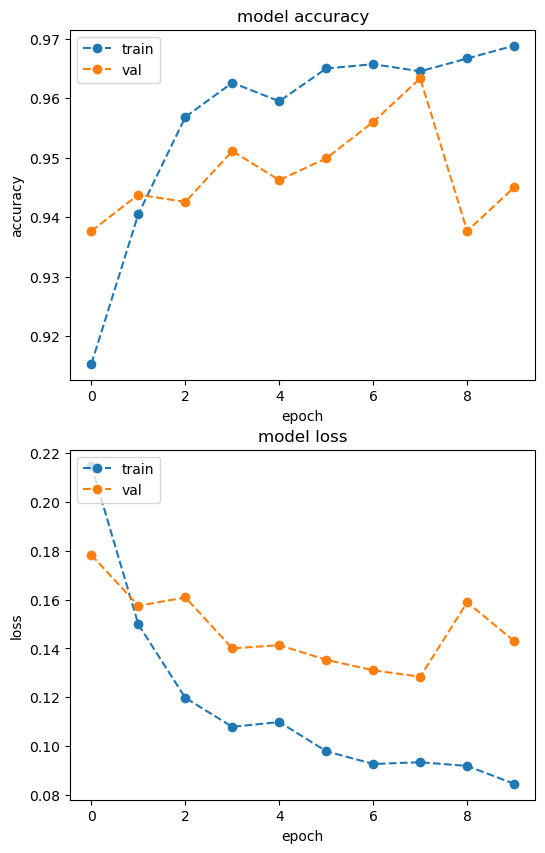

In [67]:
fix, (ax1, ax2) = plt.subplots(2, figsize=(6, 10))

# summarize history for accuracy
ax1.plot(history.history['accuracy'], "o--")
ax1.plot(history.history['val_accuracy'], "o--")
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

# summarize history for loss
ax2.plot(history.history['loss'], "o--")
ax2.plot(history.history['val_loss'], "o--")
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')
plt.show()

## 7. Evaluate both models

- Evaluate the models on data other than the training data.
- Plot a ROC curve and compute the area under the curve (AUC). What does this tell you?
- Compare to your custom-made CNN: which one achieves better results (and why)? Which one trains faster (and why)? What would you prefer to use in an actual medical application?

#### Evaluation/ROC: customized_cnn

In [158]:
y_pred_customized = cnn_customized_model.predict(test_generator)

28/28 [==============================] - 12s 433ms/step


In [159]:
y_true_customized = test_generator.labels

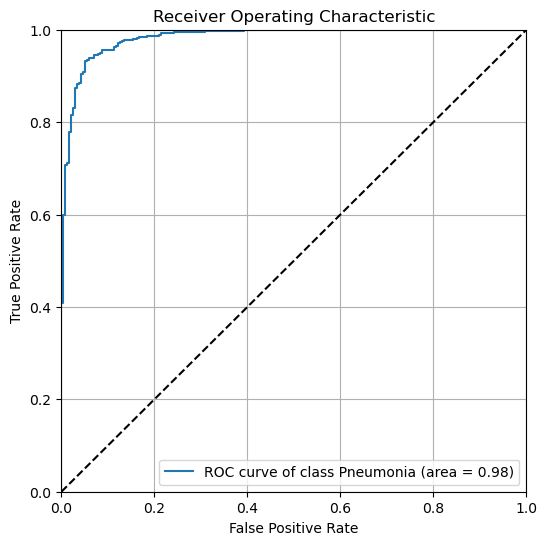

In [164]:
# Code for binary classification model

from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true_customized, y_pred_customized)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
fig, ax = plt.subplots(figsize=(6, 6))

label = "Pneumonia"

ax.plot(fpr, tpr, label='ROC curve of class {0} (area = {1:0.2f})'.format(label, roc_auc))

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend(loc="lower right")
plt.grid(True)
plt.show()

#### Evaluation/ROC: densenet classifier

In [161]:
y_pred_densenet = model_densenet.predict(densenet_test_generator)

28/28 [==============================] - 58s 2s/step


In [162]:
y_true_densenet = densenet_test_generator.labels

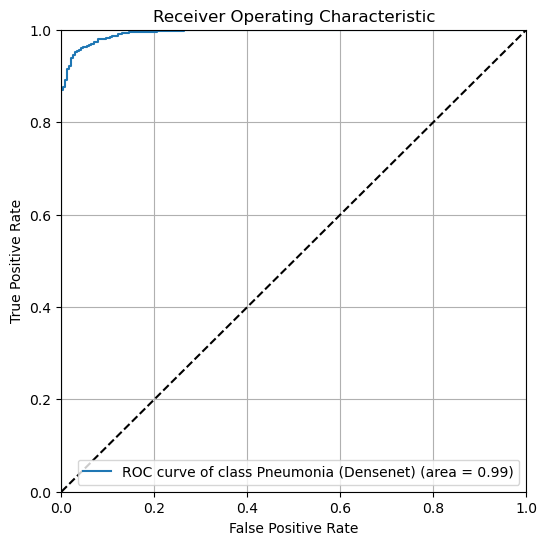

In [165]:
# Code for binary classification model

from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true_densenet, y_pred_densenet)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
fig, ax = plt.subplots(figsize=(6, 6))

label = "Pneumonia (Densenet)"

ax.plot(fpr, tpr, label='ROC curve of class {0} (area = {1:0.2f})'.format(label, roc_auc))

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend(loc="lower right")
plt.grid(True)
plt.show()

- Plot a ROC curve and compute the area under the curve (AUC). What does this tell you?

The AUC (Area Under the Curve) is a metric used to evaluate (binary) classification models. It can be used to measure the quality of machine learning models and their ability to discriminate between positive and negative classes. 
The AUC ranges from 0 to 1, with 0.5 indicating random guessing and 1 representing perfect discrimination. Higher AUC values indicate better model performance. AUC provides an overall measure of the model's predictive ability and helps compare different models or thresholds.

- Compare to your custom-made CNN: which one achieves better results (and why)? Which one trains faster (and why)? What would you prefer to use in an actual medical application?

Performance data customized model:
- epochs take about 200s
- loss in last epoch: 0.1054
- accuracy in last epoch: 0.9652
- val_loss in last epoch: 0.1751 (went up in the last four epochs)
- val_accuracy: 0.9352 (went down in last three epochs)

Performance data densenet:
- epochs take about 320s
- loss in last epoch: 0.0870
- accuracy in last epoch: 0.9662
- precision in last epoch: 0.9763
- recall in last epoch: 0.9779
- val_loss in last epoch: 0.1254
- val_accuracy in last epoch: 0.9584
- val_precision in last epoch: 0.9701
- val_recall in last epoch: 0.9701 (became better, worse and better again during the epochs)

The customized model is faster (maybe because the densenet has more than 10 times as many parameters. More parameters -> more backpropagation -> more updating of weights). The densenet model performs better in loss and val_loss ans also in val_accuracy (slightly). 

The customized model achieves a ROC-curve of 0.98 and the densenet of 0.99.

The overall rather better performance of the densenet model is probably due to the larger architecture. Densenet consists of much more layers and parameters than my customized model. The more parameters a model has, the more information it can learn from a given dataset.

For medical uses, I would prefer the densenet model. It takes a bit longer, but it achieves (slightly) better results. Also a lot more people are familiar with densenet than with my model, it has been used and tested in medical applications before. In general, if I wouldn't have to consider time limitations or energy consumption, I would always prefer a larger model to a smaller one, since, as I already pointed out, the larger a model is, the better are its predictions.

## 8. Train a CNN for a multi-class prediction (bacteria, virus, none)

In [98]:
# I modified the customized CNN for the multi-class prediction

# I chose "categorical" as class_mode, since it supports multi-label output

label_column = "infection_type"

train_generator_multiclass = image_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col="image_path",
        y_col=label_column,
        target_size=(320,320), # reshape to desired format
        batch_size=32,
        class_mode="categorical",
        color_mode="grayscale")

val_generator_multiclass = image_generator.flow_from_dataframe(
        dataframe=val_df,
        x_col="image_path",
        y_col=label_column,
        target_size=(320,320), # reshape to desired format
        batch_size=32,
        class_mode="categorical",
        shuffle=False,
        color_mode="grayscale")

test_generator_multiclass = image_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col="image_path",
        y_col=label_column,
        target_size=(320,320), # reshape to desired format
        batch_size=32,
        class_mode="categorical",
        shuffle=False,
        color_mode="grayscale")

Found 4169 validated image filenames belonging to 3 classes.
Found 818 validated image filenames belonging to 3 classes.
Found 869 validated image filenames belonging to 3 classes.


In [117]:
len(label_column)

14

In [99]:
inputs = Input(shape=(320, 320, 1)) # dimensionality of input shapes, 1 because grayscale images
#Convolution part
x = Conv2D(32, (3,3), activation="relu")(inputs)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation="relu")(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(128, (3,3), activation="relu")(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(128, (3,3), activation="relu")(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(128, (3,3), activation="relu")(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(128, (3,3), activation="relu")(x)
x = MaxPooling2D((2,2))(x)

# Dense (decision) part

x = Flatten()(x)
x = Dense(64, activation="relu")(x)

# Dense(units, activation=)
# units: dimensionality of the output space
outputs_multiclass =  Dense(3, activation="softmax")(x) # 3 output nodes
# softmax maps its inputs to a probability distribution over multiple classes -> ideal for multiclass prediction

cnn_customized_model_multiclass = Model(inputs=inputs, outputs=outputs_multiclass)
cnn_customized_model_multiclass.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 320, 320, 1)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 318, 318, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 159, 159, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 157, 157, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 78, 78, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 76, 76, 128)       7385

In [100]:
metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'), #High precision and high recall are desirable
    tf.keras.metrics.Recall(name='recall')
]

# Compile the model
cnn_customized_model_multiclass.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=metrics)

In [102]:
# insert checkpoints before training

# save model checkpoints
cnn_multiclass_path = "portfolio_checkpoints/cnn_multiclass.ckpt"

# Create a callback that saves the model's weights
save_weights_multiclass = tf.keras.callbacks.ModelCheckpoint(filepath=cnn_multiclass_path,
                                                 save_weights_only=True,    # saving only the weights, because we have the architecture of the model
                                                 verbose=1, 
                                                 monitor='val_accuracy',    # we are monitoring the accuracy on the validation set
                                                 mode='max',                # the greatest accuracy on the validation is the best outcome
                                                 save_best_only=True)       # we only want to save the best model. The other chechpoints are not interesting to us

In [103]:
cnn_customized_model_multiclass.load_weights(cnn_multiclass_path)

In [121]:
# Train the model
history = cnn_customized_model_multiclass.fit(
    train_generator_multiclass, 
    validation_data=val_generator_multiclass, 
    epochs=10,
    verbose=1,
    callbacks=[save_weights_multiclass],
)

Epoch 1/10
131/131 [==============================] - ETA: 0s - loss: 0.9603 - accuracy: 0.5483 - precision: 0.6738 - recall: 0.2487
Epoch 1: val_accuracy improved from -inf to 0.68949, saving model to portfolio_checkpoints\cnn_multiclass.ckpt
131/131 [==============================] - 187s 1s/step - loss: 0.9603 - accuracy: 0.5483 - precision: 0.6738 - recall: 0.2487 - val_loss: 0.7301 - val_accuracy: 0.6895 - val_precision: 0.7553 - val_recall: 0.5697
Epoch 2/10
131/131 [==============================] - ETA: 0s - loss: 0.6173 - accuracy: 0.7299 - precision: 0.7748 - recall: 0.6716
Epoch 2: val_accuracy improved from 0.68949 to 0.74328, saving model to portfolio_checkpoints\cnn_multiclass.ckpt
131/131 [==============================] - 197s 2s/step - loss: 0.6173 - accuracy: 0.7299 - precision: 0.7748 - recall: 0.6716 - val_loss: 0.6385 - val_accuracy: 0.7433 - val_precision: 0.7604 - val_recall: 0.7139
Epoch 3/10
131/131 [==============================] - ETA: 0s - loss: 0.5091 - ac

In [122]:
# epochs take about 190s
# loss in last epoch: 0.2954
# accuracy in last epoch: 0.8786
# precision in last epoch: 0.8844
# recall in last epoch: 0.8734 
# val_loss in last epoch: 0.5282 (became lower, higher and lower again during the epochs)
# val_accuracy: val_accuracy: 0.8105
# val_precision in last epoch: 0.8158
# val_recall in last epoch: 0.8068

## 9. Evaluate the multi-class model

- Evaluate the multi-class prediction model, simliar to what you did in (7.). Again also include a ROC curve (now of course for all 3 possible labels).
- Is the performance comparable, better, worse than the pneumonia/no pneumonia case?
- Which label can be predicted with the highest precision?

Performance of multi-class model:

- epochs take about 190s
- loss in last epoch: 0.2954
- accuracy in last epoch: 0.8786
- precision in last epoch: 0.8844
- recall in last epoch: 0.8734 
- val_loss in last epoch: 0.5282 (became lower, higher and lower again during the epochs)
- val_accuracy: val_accuracy: 0.8105
- val_precision in last epoch: 0.8158
- val_recall in last epoch: 0.8068

The multiclass model is about as fast as my first customized model and faster than the densenet model. Again, this is due to the larger architecture with more parameters in densenet. All in all, concerning loss, accuracy, val_loss, val_accuracy, the multi-class model performs worse than the first customized model and the densenet model. This makes sense - in the first two models, the whole dataset was divided between two classes. In the multiclass model, the same dataset is divided between three classes, making the available training dataset for each class smaller, so there is fewer data to learn good, robust predictions.

In [166]:
train_generator_multiclass.class_indices.keys()

dict_keys(['bacteria', 'none', 'virus'])

28/28 [==============================] - 13s 437ms/step


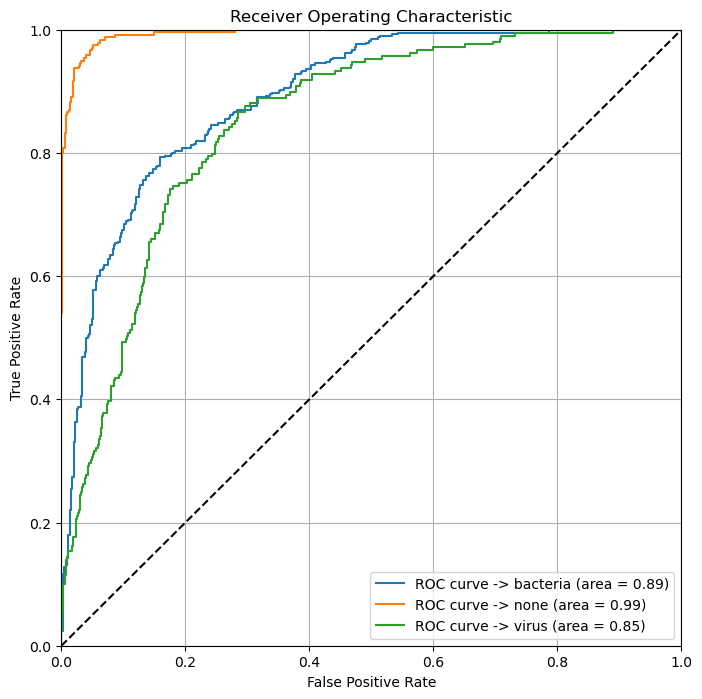

In [167]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

y_pred_multiclass = cnn_customized_model_multiclass.predict(test_generator_multiclass)
y_true_multiclass = test_generator_multiclass.labels

# Get the list of classes
classes = list(train_generator_multiclass.class_indices.keys())

# Binarize the output (one-hot encode)
y_true_bin_multiclass = label_binarize(y_true_multiclass, classes=np.arange(len(classes)))

# Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Then compute the ROC curve and AUC for each class
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin_multiclass[:, i], y_pred_multiclass[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
fig, ax = plt.subplots(figsize=(8, 8))

for i in range(len(classes)):
    ax.plot(fpr[i], tpr[i],
            label=f"ROC curve -> {classes[i]} (area = {roc_auc[i]:.2f})")

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend(loc="lower right")
plt.grid(True)
plt.show()

Here, the ROC curve for "none" is 0.99, for "bacteria" 0.89 and for "virus" 0.85. So the ROC curve for "none" is as good as the ROC curve of my densenet model, while the ROC curves for "bacteria" and "viral" perform worse.  
#### This makes a lot of sense though!
The "none" group in the multiclass model is as big as the "normal" group in the other two models we trained before. So all models have the same amount of data of patients that do not suffer from pneumonia. So of course, the training for this group should be about equally good in multiclass and binary models. 
The whole "pneumonia" group of the first two models has been divided between the cases "bacterial" and "virus" in the multiclass model. So there is fewer data for these groups than there was in the pneumonia group of the first two models. Fewer training data leads to worse predictions.
The dataset vor "virus" is also a bit smaller than the one for "bacteria". This is also consistent with the worse ROC curve.

## 10. Possible improvements

Try two possible strategies to improve the results you got on 8. and 9.
- Data augmentation.

Augmentation is only used in the training data set.

Data augmentation is used to enhance the model's ability to generalize, by giving it a lot of different variations of the data set.
The test (and validation) data should remain without augmentation since it is used to find out how the model performs on "real" data.

In [168]:
# Normalize images
image_generator_augmented = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=5, #random rotation of image by x degrees
    zoom_range=0.1,
    shear_range=2.0 # shear intensity. (Shear angle in counter-clockwise direction in degrees)
    
)

validation_generator_not_augmented = ImageDataGenerator(
    rescale=1.0/255,)

In [169]:
label_column = "infection_type"

In [172]:
train_generator_multiclass_augmented = image_generator_augmented.flow_from_dataframe(
        dataframe=train_df,
        x_col="image_path",
        y_col=label_column,
        target_size=(320,320), # reshape to desired format
        batch_size=32,
        class_mode="categorical",
        color_mode="grayscale")

# even though val and test_generator are not augmented, I called them "augmented" to mark them as a part of the
# train/test process that also includes the augmented training data
val_generator_multiclass_augmented = validation_generator_not_augmented.flow_from_dataframe(
        dataframe=val_df,
        x_col="image_path",
        y_col=label_column,
        target_size=(320,320), # reshape to desired format
        batch_size=32,
        class_mode="categorical",
        shuffle=False,
        color_mode="grayscale")

test_generator_multiclass_augmented = validation_generator_not_augmented.flow_from_dataframe(
        dataframe=test_df,
        x_col="image_path",
        y_col=label_column,
        target_size=(320,320), # reshape to desired format
        batch_size=32,
        class_mode="categorical",
        shuffle=False,
        color_mode="grayscale")

Found 4169 validated image filenames belonging to 3 classes.
Found 818 validated image filenames belonging to 3 classes.
Found 869 validated image filenames belonging to 3 classes.


In [173]:
# insert checkpoints before training

# save model checkpoints
cnn_multiclass_path_augmented = "portfolio_checkpoints/cnn_multiclass_augmented.ckpt"

# Create a callback that saves the model's weights
save_weights_multiclass_augmented = tf.keras.callbacks.ModelCheckpoint(filepath=cnn_multiclass_path_augmented,
                                                 save_weights_only=True,    # saving only the weights, because we have the architecture of the model
                                                 verbose=1, 
                                                 monitor='val_accuracy',    # we are monitoring the accuracy on the validation set
                                                 mode='max',                # the greatest accuracy on the validation is the best outcome
                                                 save_best_only=True)       # we only want to save the best model. The other chechpoints are not interesting to us

In [174]:
cnn_customized_model_multiclass.load_weights(cnn_multiclass_path_augmented)

We do not define a new model architecture for this, since we want to find out, how our last model from task 8) performs on augmented data.

In [129]:
# Train the model
history = cnn_customized_model_multiclass.fit(
    train_generator_multiclass_augmented, 
    validation_data=val_generator_multiclass_augmented, 
    epochs=10,
    verbose=1,
    callbacks=[save_weights_multiclass_augmented],
)

Epoch 1/10
131/131 [==============================] - ETA: 0s - loss: 0.4604 - accuracy: 0.8026 - precision: 0.8175 - recall: 0.7877
Epoch 1: val_accuracy improved from -inf to 0.80807, saving model to portfolio_checkpoints\cnn_multiclass_augmented.ckpt
131/131 [==============================] - 193s 1s/step - loss: 0.4604 - accuracy: 0.8026 - precision: 0.8175 - recall: 0.7877 - val_loss: 0.4706 - val_accuracy: 0.8081 - val_precision: 0.8117 - val_recall: 0.7958
Epoch 2/10
131/131 [==============================] - ETA: 0s - loss: 0.4335 - accuracy: 0.8129 - precision: 0.8290 - recall: 0.8021
Epoch 2: val_accuracy did not improve from 0.80807
131/131 [==============================] - 204s 2s/step - loss: 0.4335 - accuracy: 0.8129 - precision: 0.8290 - recall: 0.8021 - val_loss: 0.4764 - val_accuracy: 0.7983 - val_precision: 0.8073 - val_recall: 0.7836
Epoch 3/10
131/131 [==============================] - ETA: 0s - loss: 0.4110 - accuracy: 0.8239 - precision: 0.8354 - recall: 0.8110
E

In [135]:
# epochs take about 200s
# loss in last epoch: 0.3204
# accuracy in last epoch: 0.8686
# precision in last epoch: 0.8768
# recall in last epoch: 0.8606
# val_loss in last epoch: 0.5220 (became higher during the epochs)
# val_accuracy: val_accuracy: 0.8130
# val_precision in last epoch: 0.8174
# val_recall in last epoch: 0.8044

28/28 [==============================] - 12s 428ms/step


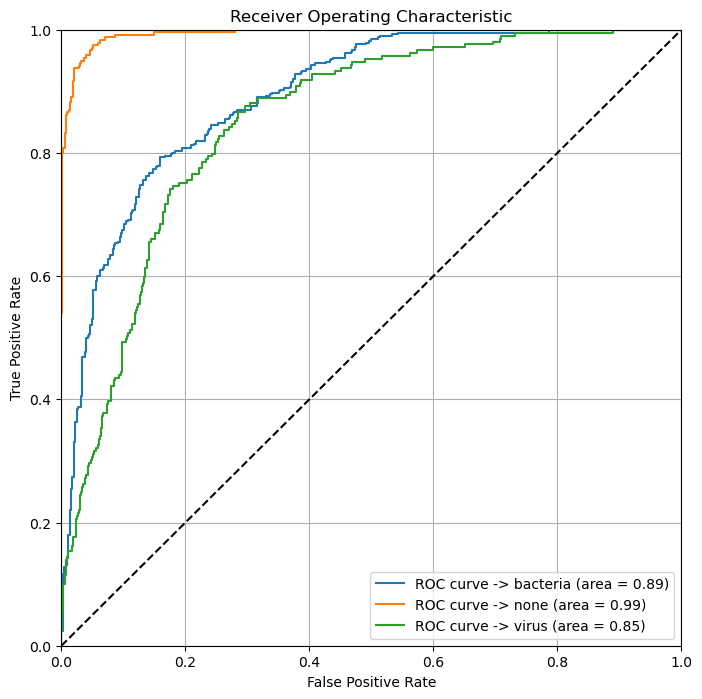

In [124]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

y_pred_augmented = cnn_customized_model_multiclass.predict(test_generator_multiclass_augmented)
y_true_augmented = test_generator_multiclass_augmented.labels

# Get the list of classes
classes = list(train_generator_multiclass_augmented.class_indices.keys())

# Binarize the output (one-hot encode)
y_true_bin_augmented = label_binarize(y_true_augmented, classes=np.arange(len(classes)))

# Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Then compute the ROC curve and AUC for each class
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin_augmented[:, i], y_pred_augmented[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
fig, ax = plt.subplots(figsize=(8, 8))

for i in range(len(classes)):
    ax.plot(fpr[i], tpr[i],
            label=f"ROC curve -> {classes[i]} (area = {roc_auc[i]:.2f})")

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend(loc="lower right")
plt.grid(True)
plt.show()

- Model fine tuning. This refers to the training of a large network with lower learning rate, but with more layers of the base model being set to trainable. We haven't done this before, so here some example code of how to "unfreeze" some layers and make them trainable again:
[Code]

In [125]:
print(f"Our model has {len(cnn_customized_model_multiclass.layers)} layers!")

Our model has 16 layers!


In [126]:
# Now: unfreeze some of the base model layers and do a second pass of training
for layer in cnn_customized_model_multiclass.layers[:100]:
    layer.trainable = False
for layer in cnn_customized_model_multiclass.layers[100:]:
    layer.trainable = True
    
    
# Create an instance of the Adam optimizer with the desired learning rate
optimizer = Adam(learning_rate=1e-5)
    
# Compile the model with the custom optimizer
cnn_customized_model_multiclass.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=metrics)

In [127]:
# insert checkpoints before training

# save model checkpoints
cnn_multiclass_path_tuned = "portfolio_checkpoints/cnn_multiclass_tuned.ckpt"

# Create a callback that saves the model's weights
save_weights_multiclass_tuned = tf.keras.callbacks.ModelCheckpoint(filepath=cnn_multiclass_path_tuned,
                                                 save_weights_only=True,    # saving only the weights, because we have the architecture of the model
                                                 verbose=1, 
                                                 monitor='val_accuracy',    # we are monitoring the accuracy on the validation set
                                                 mode='max',                # the greatest accuracy on the validation is the best outcome
                                                 save_best_only=True)       # we only want to save the best model. The other chechpoints are not interesting to us

In [115]:
cnn_customized_model_multiclass.load_weights(cnn_multiclass_path_tuned)

In [134]:
# Train the model
history = cnn_customized_model_multiclass.fit(
    train_generator_multiclass, 
    validation_data=val_generator_multiclass, 
    epochs=10,
    verbose=1,
    callbacks=[save_weights_multiclass_tuned],
)

Epoch 1/10
131/131 [==============================] - ETA: 0s - loss: 0.1692 - accuracy: 0.9340 - precision: 0.9165 - recall: 0.9116
Epoch 1: val_accuracy improved from -inf to 0.81296, saving model to portfolio_checkpoints\cnn_multiclass_tuned.ckpt
131/131 [==============================] - 74s 557ms/step - loss: 0.1692 - accuracy: 0.9340 - precision: 0.9165 - recall: 0.9116 - val_loss: 0.5220 - val_accuracy: 0.8130 - val_precision: 0.8174 - val_recall: 0.8044
Epoch 2/10
131/131 [==============================] - ETA: 0s - loss: 0.1692 - accuracy: 0.9340 - precision: 0.9357 - recall: 0.9326
Epoch 2: val_accuracy did not improve from 0.81296
131/131 [==============================] - 73s 558ms/step - loss: 0.1692 - accuracy: 0.9340 - precision: 0.9357 - recall: 0.9326 - val_loss: 0.5220 - val_accuracy: 0.8130 - val_precision: 0.8174 - val_recall: 0.8044
Epoch 3/10
131/131 [==============================] - ETA: 0s - loss: 0.1692 - accuracy: 0.9340 - precision: 0.9357 - recall: 0.9326
E

In [139]:
# epochs take about 75s
# loss in last epoch: 0.1692 (didn't change over the epochs??)
# accuracy in last epoch: 0.9340
# precision in last epoch: 0.9357
# recall in last epoch: 0.9326
# val_loss in last epoch: 0.5220
# val_accuracy: val_accuracy: 0.8130
# val_precision in last epoch: 0.8174
# val_recall in last epoch: 0.8044

# none of the values changed during the training

In [116]:
y_pred_multiclass_tuned = cnn_customized_model_multiclass.predict(test_generator_multiclass)

26/26 [==============================] - 12s 452ms/step


In [117]:
y_true_multiclass_tuned = test_generator_multiclass.labels

28/28 [==============================] - 13s 434ms/step


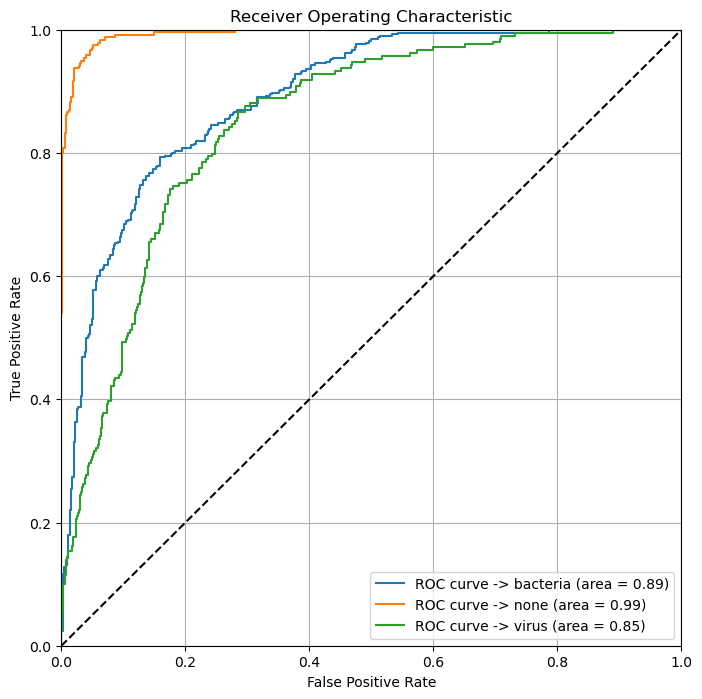

In [128]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

y_pred_multiclass_tuned = cnn_customized_model_multiclass.predict(test_generator_multiclass)
y_true_multiclass_tuned = test_generator_multiclass.labels

# Get the list of classes
classes = list(train_generator_multiclass.class_indices.keys())

# Binarize the output (one-hot encode)
y_true_bin_multiclass_tuned = label_binarize(y_true_multiclass_tuned, classes=np.arange(len(classes)))

# Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Then compute the ROC curve and AUC for each class
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin_multiclass_tuned[:, i], y_pred_multiclass_tuned[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
fig, ax = plt.subplots(figsize=(8, 8))

for i in range(len(classes)):
    ax.plot(fpr[i], tpr[i],
            label=f"ROC curve -> {classes[i]} (area = {roc_auc[i]:.2f})")

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend(loc="lower right")
plt.grid(True)
plt.show()

- Do you see any promising effect of one or both of those strategies?